In [1]:
import xarray as xr
from matplotlib import pyplot as plt
import numpy as np
import pickle
import itertools
import glob
import warnings
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import numpy as np

from minghao_utils import *
from matplotlib.animation import FuncAnimation
from tqdm import tqdm
from sklearn.cluster import KMeans
from minghao_utils import seed_everything

warnings.filterwarnings("ignore")

SST_DATA_PATH = "/l/users/minghao.fu/dataset/CESM2/CESM2_pacific_SST.pkl"
AREAS_DATA_DIR = "/l/users/minghao.fu/dataset/CESM2/group_region/"
SPACE_INDEX_DATA_PATH = "/l/users/minghao.fu/dataset/CESM2/CESM2_pacific.pkl"
VIS_DIR_PATH = "/l/users/minghao.fu/dataset/CESM2/figures/"
ANIMATE_PATH = "/l/users/minghao.fu/dataset/CESM2/animation"

TS_LEN=3

seed_everything(42)
# replace "CESM2_pacific_SST" with the file you which to visualize.
f = open(SST_DATA_PATH, 'rb')
SST = pickle.load(f)
f.close()
# metadata file
f = open(SPACE_INDEX_DATA_PATH, 'rb')
coords = pickle.load(f).drop_dims('time')
f.close()

<xarray.DataArray 'SST' (time: 6000, nlat: 186, nlon: 151)>
array([[[        nan,         nan,         nan, ..., 19.66043854,
         20.26671028,         nan],
        [        nan,         nan,         nan, ..., 19.94947052,
         20.52776909,         nan],
        [        nan,         nan,         nan, ..., 20.22084808,
         20.74257469,         nan],
        ...,
        [        nan,         nan,         nan, ..., 23.37714195,
         23.24163818, 23.11976814],
        [        nan,         nan,         nan, ..., 23.11575127,
         22.98868752, 22.85124969],
        [        nan,         nan,         nan, ..., 22.84824753,
         22.72991753, 22.58181572]],

       [[        nan,         nan,         nan, ..., 19.69541168,
         20.33510971,         nan],
        [        nan,         nan,         nan, ..., 19.97130394,
         20.58953094,         nan],
        [        nan,         nan,         nan, ..., 20.26950836,
         20.85061264,         nan],
...
        [        nan,         nan,         nan, ..., 25.30422974,
         25.19849968, 25.11521912],
        [        nan,         nan,         nan, ..., 25.23148727,
         25.11697769, 25.00881958],
        [        nan,         nan,         nan, ..., 25.1598053 ,
         25.04154587, 24.91431236]],

       [[        nan,         nan,         nan, ..., 19.27692986,
         20.08394241,         nan],
        [        nan,         nan,         nan, ..., 19.48740959,
         20.35291481,         nan],
        [        nan,         nan,         nan, ..., 19.70591545,
         20.61165619,         nan],
        ...,
        [        nan,         nan,         nan, ..., 23.84464645,
         23.68166542, 23.55305672],
        [        nan,         nan,         nan, ..., 23.74078178,
         23.57515907, 23.42254639],
        [        nan,         nan,         nan, ..., 23.63164139,
         23.47472572, 23.30509949]]])
Coordinates:
  * nlat     (nlat) int32 94 95 96 97 98 99 100 ... 273 274 275 276 277 278 279
  * nlon     (nlon) int32 143 144 145 146 147 148 ... 288 289 290 291 292 293
    lat      (nlat, nlon) float64 -29.55 -29.55 -29.55 ... 29.83 29.81 29.78
    lon      (nlat, nlon) float64 120.3 121.4 122.6 123.7 ... 287.0 288.2 289.3
Dimensions without coordinates: time

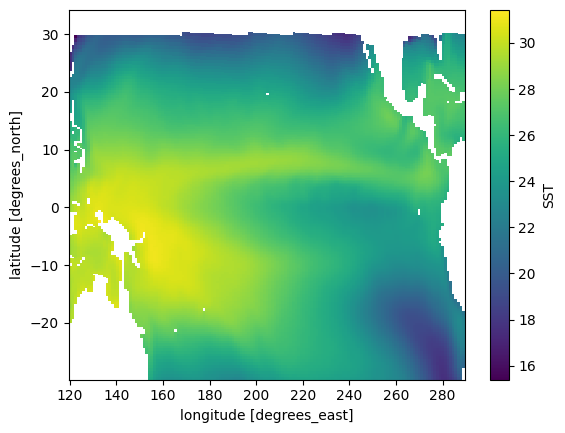

In [2]:
tSST = np.full((SST.shape[0], coords.dims.get('space_index')), np.nan)

# Now use advanced indexing to assign values in one step
tSST[:, coords.nnaSST] = SST

tst = coords.copy()
tst['SST'] = (('time', 'space_index'), tSST)

# Now you can unstack and plot as you did previously
sst_data = tst.unstack('space_index').SST
sst_data.isel(time=0).plot(x='lon', y='lat')
sst_data

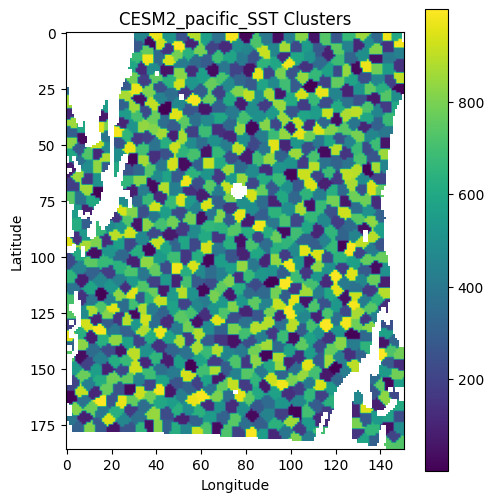

In [3]:
TS_LEN=3

# replace "CESM2_pacific_SST" with the file you which to visualize.
f = open(SST_DATA_PATH, 'rb')
SST = pickle.load(f)
f.close()
# metadata file
f = open(SPACE_INDEX_DATA_PATH, 'rb')
coords = pickle.load(f).drop_dims('time')
f.close()

n_samples = SST.shape[0]
n_dims = coords.dims.get('space_index')
n_valid_dims = SST.shape[1]

corr = np.corrcoef(SST[:, :130].T)

tSST = np.empty((SST.shape[0], coords.dims.get('space_index')))
tSST[:, ~coords.nnaSST] = np.nan
tSST[:, coords.nnaSST] = SST  #(6000, 28086)

tst = coords.copy()
tst['SST']=('space_index', tSST[0])
lat_len, lon_len = tst.unstack('space_index').SST.values.shape

lat_mat = tst.unstack('space_index').SST.lat.values
lon_mat = tst.unstack('space_index').SST.lon.values

coords_SST = tSST.copy().reshape(tSST.shape[0], lat_len, lon_len) #tst.unstack('space_index').SST.values

coords_mat = np.stack((lat_mat, lon_mat), axis=2)
coords_flat = coords_mat.copy().reshape(-1, 2)
coords_flat[~coords.nnaSST] = np.nan

coords_bin_mat = coords.nnaSST.values.reshape(lat_len, lon_len)

max_distance = 40
coords_groups = []
SST_groups = []

coords_SST[:, ~coords.nnaSST.values.reshape(lat_len, lon_len)] = 0
# Example 2D matrices

coords_SST0 = coords_SST[0]  # Replace with your actual data

rows, cols = coords_SST0.shape

# Function to create dataset with coordinates
def mat_nonzero_ele_locs(matrix, coords_bin_mat):
    rows, cols = matrix.shape
    ele_locs = [[row, col] for row in range(rows) for col in range(cols) if coords_bin_mat[row, col]]
    return np.array(ele_locs)

locs_lst = mat_nonzero_ele_locs(coords_SST0, coords_bin_mat)

# Combine datasets

# Define the number of clusters
k = 1000  # Adjust based on your requirements

# Apply K-means clustering
kmeans = KMeans(n_clusters=k)
kmeans.fit(locs_lst)



labels = kmeans.labels_
centers = kmeans.cluster_centers_
group_regions = [[] for i in range(k)]

def create_cluster_matrix(matrix: np.array, ele_locs: list, labels):
    cluster_matrix = np.zeros_like(matrix)
    for idx, (row, col) in enumerate(ele_locs):
        cluster_matrix[row, col] = labels[idx] 
        group_regions[labels[idx]].append((row, col))
    return cluster_matrix

cluster_coords_SST0 = create_cluster_matrix(coords_SST0, locs_lst, labels)  

# Mask the array: mask 0 values, not plot them
masked_array = np.ma.masked_where(cluster_coords_SST0 == 0, cluster_coords_SST0)

# Define a colormap: 'viridis' but with a custom color for masked values (white)
cmap = plt.cm.viridis
cmap.set_bad(color='white')

# Plotting
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title("CESM2_pacific_SST Clusters")
#plt.imshow(cluster_coords_SST0, cmap='viridis')
plt.imshow(masked_array, cmap=cmap)  # Use the masked array here
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.colorbar()


In [4]:

# Define the number of clusters
second_k = 10  # Adjust based on your requirements

# Apply K-means clustering
second_kmeans = KMeans(n_clusters=second_k)
second_kmeans.fit(np.array(centers))


second_centers = second_kmeans.cluster_centers_

second_labels = []
region_tree = [[[] for i in range(k)] for i in range(second_k)]
second_group_regions = [[] for i in range(second_k)]

second_cluster_matrix = np.zeros_like(coords_SST0)
rows, cols = second_cluster_matrix.shape
for idx, (row, col) in enumerate(locs_lst):
    if coords_bin_mat[row, col]:
        second_cluster_matrix[row, col]
        second_label = second_kmeans.labels_[labels[idx]]
        second_labels.append(second_label)

        region_tree[second_label][labels[idx]].append([second_label, labels[idx], row, col])

for i in range(second_k):
    region_tree[i] = [sublist for sublist in region_tree[i] if sublist]

causal_group_coords_SST0 = create_cluster_matrix(coords_SST0, locs_lst, second_labels)

In [5]:
area_indices = np.full_like(sst_data[0].values, np.nan)
group_indices = np.full_like(sst_data[0].values, np.nan)

for i in region_tree:
    for j in i:
        for second_label, first_label, row, col in j:
            #if coords_bin_mat[row, col]:
            group_indices[row, col] = first_label
            area_indices[row, col] = second_label
            # else:
            #     group_indices[row, col] = -1
            #     area_indices[row, col] = -1

group_indices_da = xr.DataArray(group_indices, coords=sst_data.coords, dims=sst_data.dims[1:])
area_indices_da = xr.DataArray(area_indices, coords=sst_data.coords, dims=sst_data.dims[1:])

# Assign the new DataArray as a coordinate to your original DataArray
grouped_sst_data = sst_data.copy().assign_coords(group_index=group_indices_da).assign_coords(area_index=area_indices_da)

In [6]:
# Calculate the mean for each group across the 'time' dimension
group_means = grouped_sst_data.groupby('group_index').mean(skipna=True)

# for i in range(len(grouped_sst_data.nlat)):
#     for j in range(len(grouped_sst_data.nlon)):
#         idx = int(grouped_sst_data[:, i, j]['group_index'])
#         if coords_bin_mat[i, j]:
#             grouped_sst_data[:, i, j] = group_means[:, idx]
#         else:
#             grouped_sst_data[:, i, j] = np.nan

for idx, (i, j) in enumerate(locs_lst):
    idx = int(grouped_sst_data[:, i, j]['group_index'])
    grouped_sst_data[:, i, j] = group_means[:, idx]

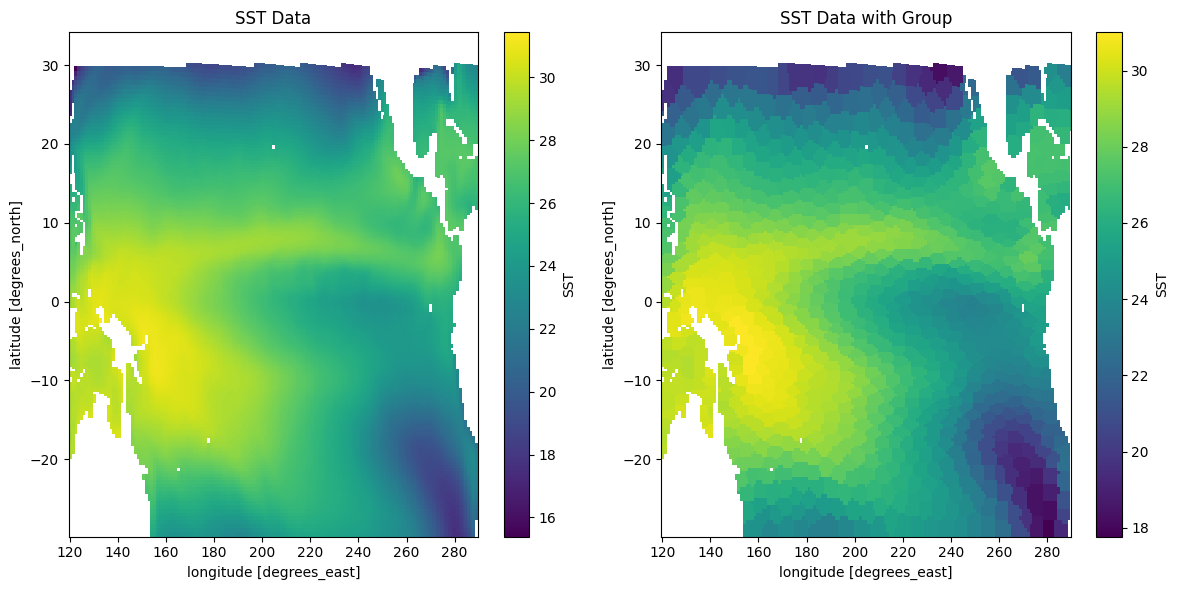

In [7]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
sst_data.isel(time=0).plot(x='lon', y='lat', ax=axes[0])
axes[0].set_title('SST Data')

grouped_sst_data.isel(time=0).plot(x='lon', y='lat', ax=axes[1])
axes[1].set_title('SST Data with Group')

plt.tight_layout()
plt.show()


In [9]:
# save xarray to .nc file
save_path="/l/users/minghao.fu/dataset/CESM2/CESM2_pacific_grouped_SST.nc"
grouped_sst_data.to_netcdf(save_path)
grouped_sst_data

<xarray.DataArray 'SST' (time: 6000, nlat: 186, nlon: 151)>
array([[[        nan,         nan,         nan, ..., 19.28315576,
         19.28315576,         nan],
        [        nan,         nan,         nan, ..., 19.28315576,
         19.28315576,         nan],
        [        nan,         nan,         nan, ..., 19.28315576,
         19.28315576,         nan],
        ...,
        [        nan,         nan,         nan, ..., 23.35205801,
         23.35205801, 23.35205801],
        [        nan,         nan,         nan, ..., 23.35205801,
         23.35205801, 23.35205801],
        [        nan,         nan,         nan, ..., 23.35205801,
         23.35205801, 23.35205801]],

       [[        nan,         nan,         nan, ..., 19.37200504,
         19.37200504,         nan],
        [        nan,         nan,         nan, ..., 19.37200504,
         19.37200504,         nan],
        [        nan,         nan,         nan, ..., 19.37200504,
         19.37200504,         nan],
...
        [        nan,         nan,         nan, ..., 25.30481005,
         25.30481005, 25.30481005],
        [        nan,         nan,         nan, ..., 25.30481005,
         25.30481005, 25.30481005],
        [        nan,         nan,         nan, ..., 25.30481005,
         25.30481005, 25.30481005]],

       [[        nan,         nan,         nan, ..., 18.74900468,
         18.74900468,         nan],
        [        nan,         nan,         nan, ..., 18.74900468,
         18.74900468,         nan],
        [        nan,         nan,         nan, ..., 18.74900468,
         18.74900468,         nan],
        ...,
        [        nan,         nan,         nan, ..., 23.82281168,
         23.82281168, 23.82281168],
        [        nan,         nan,         nan, ..., 23.82281168,
         23.82281168, 23.82281168],
        [        nan,         nan,         nan, ..., 23.82281168,
         23.82281168, 23.82281168]]])
Coordinates:
  * nlat         (nlat) int32 94 95 96 97 98 99 100 ... 274 275 276 277 278 279
  * nlon         (nlon) int32 143 144 145 146 147 148 ... 289 290 291 292 293
    lat          (nlat, nlon) float64 -29.55 -29.55 -29.55 ... 29.83 29.81 29.78
    lon          (nlat, nlon) float64 120.3 121.4 122.6 ... 287.0 288.2 289.3
    group_index  (nlat, nlon) float64 nan nan nan nan ... 729.0 729.0 729.0
    area_index   (nlat, nlon) float64 nan nan nan nan nan ... 5.0 5.0 5.0 5.0
Dimensions without coordinates: time